# Avaliação técnica - Gabriel Negrelli

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Leitura e condicionamento dos dados

Primeiro, é realizada a leitura dos dados disponibilizados no [kaggle](https://www.kaggle.com/uciml/electric-power-consumption-data-set). Os campos preenchidos com o valor `?` são considerados como sendo `NaN`. As colunas contendo a data e o horário das medidas são unidos em uma só coluna e interpretados como sendo do tipo`pandas.datetime`.

In [2]:
df = pd.read_csv('./electric-power-consumption-data-set/household_power_consumption.txt', sep=';', 
                 na_values='?', parse_dates=[['Date', 'Time']])

Em seguida, as colunas são renomeadas para melhor compreensão dos dados contidos no dataset. Alem disso, a coluna contendo os horários das medidas é utilizada como índice do dataframe.

In [3]:
columns = {
    'Date_Time': 'Timestamp',
    'Global_active_power': 'P [kW]', 
    'Global_reactive_power': 'Q [kVAr]', 
    'Voltage': 'V [V]', 
    'Global_intensity': 'I [A]', 
    'Sub_metering_1': 'P_kitchen [Wh]', 
    'Sub_metering_2': 'P_laundry [Wh]', 
    'Sub_metering_3': 'P_heat [Wh]'
}

df.rename(columns=columns, inplace=True)

In [4]:
df.set_index('Timestamp', inplace=True)

Finalmente, são criadas as seguintes colunas com base nos dados presentes no dataset:

* P_rest [Wh]: Energia (em Wh) consumida no restante da casa.

* P [Wh]: Energia total (em Wh) consumida na residência.

* Q [VArh]: Energia reativa (em VArh) consumida na residência.

* fp: fator de potência em cada instante.

O dataframe resultante pode ser visto abaixo

In [5]:
df['P_rest [Wh]'] = df['P [kW]']*1000/60 - df['P_kitchen [Wh]'] - df['P_laundry [Wh]'] - df['P_heat [Wh]']
df['P [Wh]'] = df['P [kW]']*1000/60
df['Q [VArh]'] = df['Q [kVAr]']*1000/60
df['fp'] = df['P [Wh]']/np.sqrt(df['P [Wh]']**2 + df['Q [VArh]']**2)

In [6]:
df.head()

,P [kW],Q [kVAr],V [V],I [A],P_kitchen [Wh],P_laundry [Wh],P_heat [Wh],P_rest [Wh],P [Wh],Q [VArh],fp
Timestamp,,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667,70.266667,6.966667,0.995121
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333,89.333333,7.266667,0.996708
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667,89.566667,8.300000,0.995734
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000,89.800000,8.366667,0.995688
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000,61.100000,8.800000,0.989787


***

## Análise dos dados de consumo

Após o condicionamento dos dados, pode-se iniciar análise do consumo na residência. Foram feitas análises em relação ao consumo durante o dia, na semana, nos meses do ano e durante os anos medidos.

### Consumo diário

Primeiramente, são calculados os valores médios do consumo total da casa em cada instante do dia, assim como o consumo registrado por cada um dos três medidores e o consumo do restante da casa.

In [7]:
minute_mean = df['P [Wh]'].groupby([df.index.hour, df.index.minute]).mean().to_dict()
minute_mean_kitchen = df['P_kitchen [Wh]'].groupby([df.index.hour, df.index.minute]).mean().to_dict()
minute_mean_laundry = df['P_laundry [Wh]'].groupby([df.index.hour, df.index.minute]).mean().to_dict()
minute_mean_heat = df['P_heat [Wh]'].groupby([df.index.hour, df.index.minute]).mean().to_dict()
minute_mean_rest = df['P_rest [Wh]'].groupby([df.index.hour, df.index.minute]).mean().to_dict()

Em seguida, os valores são ordenados de acordo com o horário em que as medidas foram realizadas.

In [8]:
measures, measures_kitchen, measures_laundry, measures_heat, measures_rest, instants = [], [], [], [], [], []
for time in sorted(minute_mean.keys()):

    measures.append(minute_mean[time])
    
    instants.append('{:02d}:{:02d}'.format(time[0], time[1]))

    measures_kitchen.append(minute_mean_kitchen[time])
    measures_laundry.append(minute_mean_laundry[time])
    measures_heat.append(minute_mean_heat[time])
    measures_rest.append(minute_mean_rest[time])

Os dados obtidos para o consumo médio durante o dia na residência podem ser melhor observados nos gráficos abaixo.

Text(0,0.5,'P [Wh]')

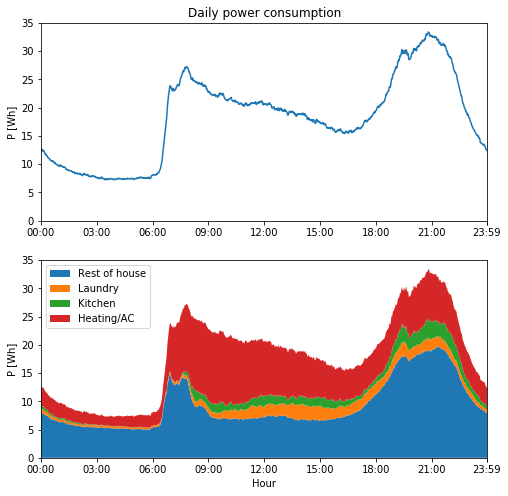

In [9]:
labels = ['Rest of house', 'Laundry', 'Kitchen', 'Heating/AC']

plt.rcParams['figure.figsize'] = [8, 8]

plt.subplot(2, 1, 1)
plt.plot(instants, measures)
plt.xticks(np.hstack((np.arange(0, 1441, 3*60), np.array([1439]))))
plt.xlim(0, 1440)
plt.ylim(0, 35)
plt.title('Daily power consumption')
plt.ylabel('P [Wh]')

plt.subplot(2, 1, 2)
plt.stackplot(instants, measures_rest, measures_laundry, measures_kitchen, measures_heat, labels=labels)
plt.legend(loc='upper left')
plt.xticks(np.hstack((np.arange(0, 1441, 3*60), np.array([1439]))))
plt.xlim(0, 1440)
plt.ylim(0, 35)
plt.xlabel('Hour')
plt.ylabel('P [Wh]')

Podemos ver que o consumo se mantém relativamente baixo durante as primeiras horas do dia, mas, por volta de 7h, há um aumento expressivo no consumo de energia, principalmente pelos equipamentos de aquecimento de água e ar condicionado. Também há um aumento do consumo de energia nos outros cômodos da residência por volta deste horário. Isso é devido ao fato deste ser o horário em que os moradores acordam, tomam banho, ligam TV's, computadores, etc.

A partir das 9h, o consumo de energia volta a cair, devido à saída dos moradores para o trabalho e/ou escola. O consumo volta a crescer por volta das 17h, horário em que os moradores retornam à residência. Além disso, já passa a ser necessário o uso de iluminação aritifical em alguns cômodos. Também há aumento no consumo de energia para aquecimento de água e ar condicionado, provavelmente por conta de chuveiros elétricos. Após as 22h, conforme os moradores vão dormindo, o consumo diminui novamente.

### Consumo semanal

Para análise do consumo semanal, foi feita a média de consumo na residência para cada dia (segunda a domingo). O gráfico abaixo nos mostra o perfil de consumo na casa para cada dia da semana.

Text(0,0.5,'Power Consumption [Wh]')

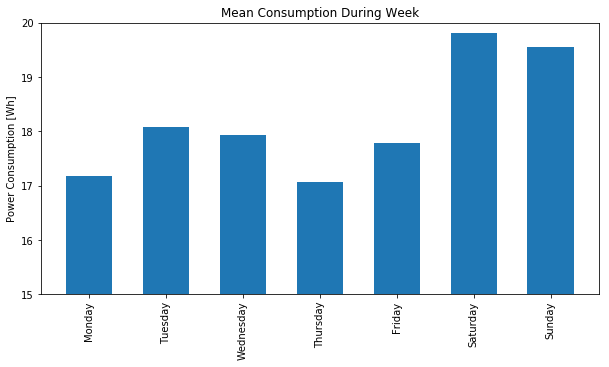

In [10]:
week_mean = df['P [Wh]'].groupby(df.index.weekday).mean().to_dict()
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 5))
plt.bar(weekdays, week_mean.values(), width=0.6)
plt.xticks(rotation='vertical')
plt.ylim(15, 20)
plt.title('Mean Consumption During Week')
plt.ylabel('Power Consumption [Wh]')

Podemos ver que o consumo de energia é maior durante os fins de semana, devido, provavelmente, ao fato dos moradores passarem mais tempo dentro de casa durante estes dias. Para entender melhor essa diferença de consumo, foram calculadas as médias de consumo para cada medidor da residência durante as terças e sábados.

In [11]:
sat = df[df.index.weekday == 5]
tue = df[df.index.weekday == 1]

sat_kitchen = sat['P_kitchen [Wh]'].groupby([sat.index.hour, sat.index.minute]).mean().to_dict()
sat_laundry = sat['P_laundry [Wh]'].groupby([sat.index.hour, sat.index.minute]).mean().to_dict()
sat_heat = sat['P_heat [Wh]'].groupby([sat.index.hour, sat.index.minute]).mean().to_dict()
sat_rest = sat['P_rest [Wh]'].groupby([sat.index.hour, sat.index.minute]).mean().to_dict()

tue_kitchen = tue['P_kitchen [Wh]'].groupby([tue.index.hour, tue.index.minute]).mean().to_dict()
tue_laundry = tue['P_laundry [Wh]'].groupby([tue.index.hour, tue.index.minute]).mean().to_dict()
tue_heat = tue['P_heat [Wh]'].groupby([tue.index.hour, tue.index.minute]).mean().to_dict()
tue_rest = tue['P_rest [Wh]'].groupby([tue.index.hour, tue.index.minute]).mean().to_dict()

sat_kitchen_measures, sat_laundry_measures, sat_heat_measures, sat_rest_measures = [], [], [], []
tue_kitchen_measures, tue_laundry_measures, tue_heat_measures, tue_rest_measures = [], [], [], []
for time in sorted(sat_rest.keys()):
    
    sat_kitchen_measures.append(sat_kitchen[time])
    sat_laundry_measures.append(sat_laundry[time])
    sat_heat_measures.append(sat_heat[time])
    sat_rest_measures.append(sat_rest[time])
    
    tue_kitchen_measures.append(tue_kitchen[time])
    tue_laundry_measures.append(tue_laundry[time])
    tue_heat_measures.append(tue_heat[time])
    tue_rest_measures.append(tue_rest[time])

Text(0,0.5,'Weekend Consumption [Wh]')

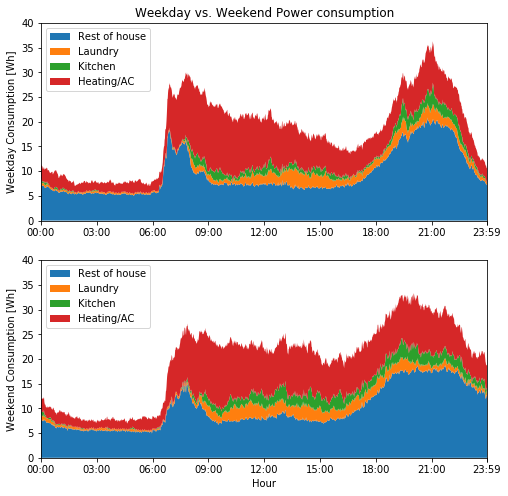

In [12]:
labels = ['Rest of house', 'Laundry', 'Kitchen', 'Heating/AC']

plt.subplot(2, 1, 1)
plt.stackplot(instants, tue_rest_measures, tue_laundry_measures, tue_kitchen_measures, tue_heat_measures, labels=labels)
plt.legend(loc='upper left')
plt.xticks(np.hstack((np.arange(0, 1441, 3*60), np.array([1439]))))
plt.xlim(0, 1440)
plt.ylim(0, 40)
plt.title('Weekday vs. Weekend Power consumption')
plt.ylabel('Weekday Consumption [Wh]')

plt.subplot(2, 1, 2)
plt.stackplot(instants, sat_rest_measures, sat_laundry_measures, sat_kitchen_measures, sat_heat_measures, labels=labels)
plt.legend(loc='upper left')
plt.xticks(np.hstack((np.arange(0, 1441, 3*60), np.array([1439]))))
plt.xlim(0, 1440)
plt.ylim(0, 40)
plt.xlabel('Hour')
plt.ylabel('Weekend Consumption [Wh]')

Nos gráficos acima podemos ver como é o perfil de consumo durante as terças e sábados. Nota-se que o pico matinal de consumo ocorre mais tarde e é menos acentuado durante os sábados, provavelmente devido ao fato dos moradores acordarem mais tarde durante os fins de semana.

No decorrer do dia, o consumo se mantém acima do normal para os dias de semana, principalmente na cozinha e lavanderia, já que os moradores se encontram em casa por maior tempo. O consumo por aquecimento de água e ar condicionado também é maior durante o fim de semana, já que o uso destes equipamentos é mais frequente.

O pico noturno durante o sábado se inicia mais cedo quando comparado aos dias da semana, e, apesar de não atingir o mesmo nível das terças, se mantém num patamar elevado por mais tempo, avançando até a madrugada de domingo. Todos estes fatores contribuem para o maior consumo de energia na residência durante o fim de semana.

### Consumo sazonal

Com o intuito de compreender como o consumo de energia varia durante o decorrer do ano, foi feita a análise de consumo sazonal. Para tal, foram obtidas as médias de consumo para cada mês do ano. Esses valores são mostrados no gráfico abaixo

Text(0,0.5,'Power Consumption [Wh]')

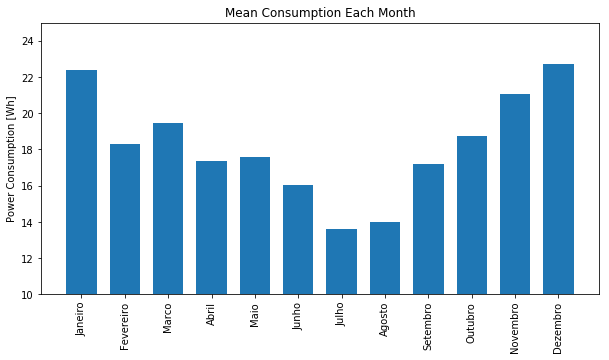

In [13]:
monthly_mean = df['P [Wh]'].groupby(df.index.month).mean().to_dict()
months = ['Janeiro', 'Fevereiro', 'Marco', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

plt.figure(figsize=(10, 5))
plt.bar(months, monthly_mean.values(), width=0.7)
plt.xticks(rotation='vertical')
plt.ylim(10, 25)

plt.title('Mean Consumption Each Month')
plt.ylabel('Power Consumption [Wh]')

Podemos ver que nos meses de inverno no hemisfério norte (Dezembro-Fevereiro) o consumo é quase 50% maior do que o registrado nos meses de verão (Junho-Agosto). Isso é devido, principalmente, às diferentes condições climáticas ocasionadas pelas estações. Possíveis viagens de férias durante o verão também influenciam fortemente para a redução de consumo nesses meses.

Para melhor entender a diferença de consumo observada entre os meses, os dados de consumo para cada medidor registrados durante os meses de junho e dezembro foram agrupados. As médias de consumo obtidas durante os períodos citados são mostradas nos gráficos abaixo.

In [14]:
jun = df[df.index.month == 6]
dec = df[df.index.month == 12]

jun_kitchen = jun['P_kitchen [Wh]'].groupby([jun.index.hour, jun.index.minute]).mean().to_dict()
jun_laundry = jun['P_laundry [Wh]'].groupby([jun.index.hour, jun.index.minute]).mean().to_dict()
jun_heat = jun['P_heat [Wh]'].groupby([jun.index.hour, jun.index.minute]).mean().to_dict()
jun_rest = jun['P_rest [Wh]'].groupby([jun.index.hour, jun.index.minute]).mean().to_dict()

dec_kitchen = dec['P_kitchen [Wh]'].groupby([dec.index.hour, dec.index.minute]).mean().to_dict()
dec_laundry = dec['P_laundry [Wh]'].groupby([dec.index.hour, dec.index.minute]).mean().to_dict()
dec_heat = dec['P_heat [Wh]'].groupby([dec.index.hour, dec.index.minute]).mean().to_dict()
dec_rest = dec['P_rest [Wh]'].groupby([dec.index.hour, dec.index.minute]).mean().to_dict()

jun_kitchen_measures, jun_laundry_measures, jun_heat_measures, jun_rest_measures = [], [], [], []
dec_kitchen_measures, dec_laundry_measures, dec_heat_measures, dec_rest_measures = [], [], [], []
for time in sorted(jun_rest.keys()):
    
    jun_kitchen_measures.append(jun_kitchen[time])
    jun_laundry_measures.append(jun_laundry[time])
    jun_heat_measures.append(jun_heat[time])
    jun_rest_measures.append(jun_rest[time])
    
    dec_kitchen_measures.append(dec_kitchen[time])
    dec_laundry_measures.append(dec_laundry[time])
    dec_heat_measures.append(dec_heat[time])
    dec_rest_measures.append(dec_rest[time])

Text(0,0.5,'Consumo durante o inverno [Wh]')

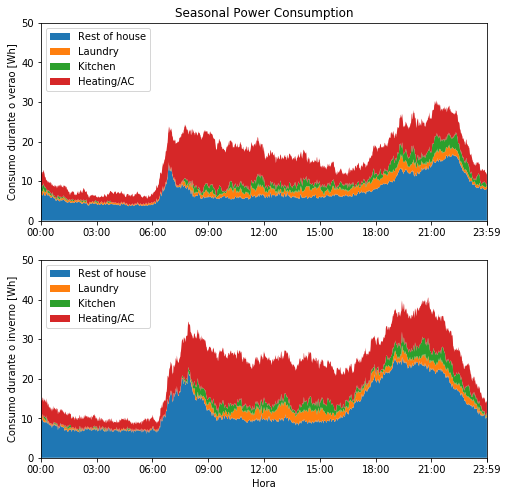

In [15]:
labels = ['Rest of house', 'Laundry', 'Kitchen', 'Heating/AC']

plt.subplot(2, 1, 1)
plt.stackplot(instants, jun_rest_measures, jun_laundry_measures, jun_kitchen_measures, jun_heat_measures, labels=labels)
plt.legend(loc='upper left')
plt.xticks(np.hstack((np.arange(0, 1441, 3*60), np.array([1439]))))
plt.xlim(0, 1440)
plt.ylim(0, 50)
plt.title('Seasonal Power Consumption')
plt.ylabel('Consumo durante o verao [Wh]')

plt.subplot(2, 1, 2)
plt.stackplot(instants, dec_rest_measures, dec_laundry_measures, dec_kitchen_measures, dec_heat_measures, labels=labels)
plt.legend(loc='upper left')
plt.xticks(np.hstack((np.arange(0, 1441, 3*60), np.array([1439]))))
plt.xlim(0, 1440)
plt.ylim(0, 50)
plt.xlabel('Hora')
plt.ylabel('Consumo durante o inverno [Wh]')

Podemos ver que o consumo dos equipamentos de aquecimento da residência atinge níveis maiores durante os dias de inverno, devido a temperaturas mais baixas durante esta época do ano. Além disso, o pico de consumo noturno se inicia mais cedo durante o mês de Dezembro. Isso é devido ao fato dos dias serem mais curtos durante o inverno, fazendo com que a necessidade de iluminação artificial ocorra mais cedo e antecipando a ocorrência do pico de consumo.

### Consumo anual

Para compreender como o perfil de consumo se modificou durante o período analisado, os dados foram agrupados e foi obtida a média de consumo para cada um dos anos em que foram feitas as medições. O resultado é mostrado no gráfico abaixo.

Text(0,0.5,'Power Consumption [Wh]')

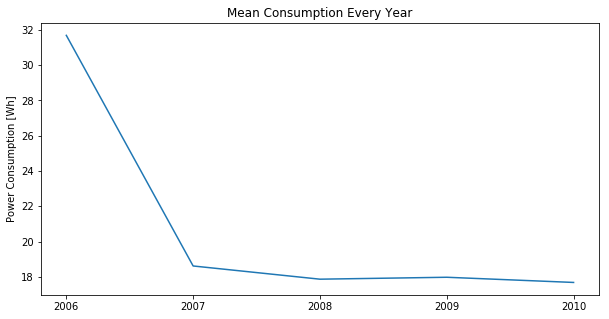

In [16]:
yearly_mean = df['P [Wh]'].groupby(df.index.year).mean().to_dict()

year, meas = [], []
for key in sorted(yearly_mean):
    year.append(key)
    meas.append(yearly_mean[key])

plt.figure(figsize=(10, 5))
plt.plot(year, meas)
plt.xticks(year)

plt.title('Mean Consumption Every Year')
plt.ylabel('Power Consumption [Wh]')

Podemos ver que o consumo no ano de 2006 foi bem maior quando comparado aos valores dos demais anos. Isso se deve ao fato do conjunto de dados só possuir medidas a partir de dezembro deste ano, justamente um dos meses de maior consumo na residência. Com isso, a média de consumo para 2006 se torna extremamente elevada. Dentre os demais anos, nota-se que o consumo se mantém praticamente estável.

***
## Qualidade da energia elétrica

Outro aspecto que pode ser analisado a partir do conjunto de dados é a qualidade da energia fornecida para a residência. Dois aspectos da eletricidade fornecida serão analisados aqui:

* Desvios de tensão: Valores 10% acima (sobretensão) ou abaixo (subtensão) do valor nominal de tensão. Para este caso, foi assumido que o valor nominal da tensão é de 240 Volts.

* Excesso de reativos: Valores altos de potência reativa consumida. Esse aspecto será analisado utilizando a medida de fator de potência (_fp_), obtida divindindo a potência ativa consumida pela raiz quadrada de P² + Q². O fator de potência é uma medida que vai de 0 a 1, e valor mínimo permitido é de 0,92.

### Desvios de tensão

A coluna correspondente a tensão medida foi filtrada para mostrar apenas os valores que infrigiram os limites de tensão. O resultado da analise é exibido abaixo.

In [17]:
V_nom = 240

V_occ = len(df[(df['V [V]'] <= 0.9*V_nom) | (df['V [V]'] >= 1.1*V_nom)])

print("Analisando os dados fornecidos, podemos concluir que houveram {} caso(s) de desvio de tensão.".format(V_occ))

Analisando os dados fornecidos, podemos concluir que houveram 0 caso(s) de desvio de tensão.


### Excesso de reativos

Com o intuito de analisar os momentos em que houve excesso de reativos na residência, o dataframe foi filtrado para exibir apenas as linhas em que o fator de potência ficou abaixo do valor mínimo.

In [18]:
reac_exc = df[df['fp'] < 0.92]

print("Analisando os dados fornecidos, podemos concluir que houveram {} momento(s) em que houve excesso de reativos.".format(len(reac_exc)))

Analisando os dados fornecidos, podemos concluir que houveram 352521 momento(s) em que houve excesso de reativos.


Abaixo foi plotado o número de ocorrências para cada instante de tempo. Vemos que a maior parte dos eventos com excesso de reativos ocorre durante a madrugada. Isso se deve ao fato deste período ser o horário com menor consumo de energia por carga ativas (comuns) na residência. Por conta disso, qualquer pequena variação de consumo de reativos por parte de equipamentos como geladeiras, máquinas de lavar e condicionadores de ar faz com que os limites do fator de potência sejam violados.

Text(0,0.5,'# of Reactive Excess Events')

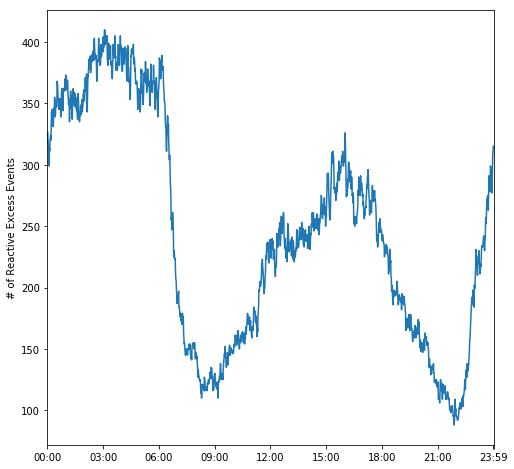

In [19]:
plt.plot(instants, reac_exc['fp'].groupby([reac_exc.index.hour, reac_exc.index.minute]).count().to_list())
plt.xticks(np.hstack((np.arange(0, 1441, 3*60), np.array([1439]))))
plt.xlim(0, 1440)

plt.ylabel('# of Reactive Excess Events')

***
## Dados complementares

Alguns dados que poderiam ser fornecidos com o intuito de enriquecer a análise são:

* Informações sobre os moradores (número de moradores, faixa etária, ocupação, período de férias);

* Dados meteorológicos (temperatura ambiente, umidade, precipitação);

* Datas de aquisição de novos equipamentos (substituição de eletrodomésticos, aquisição de painéis fotovoltaicos, carro elétrico); e

* Dados da concessionária de energia (valor do kWh, bandeira tarifária).

Em posse destes dados poderiam ser feitas análises mais concisas sobre o perfil de consumo dos residentes e quais fatores influenciam no comportamento da energia consumida.